# Notebook de Entrenamiento de Algoritmos para despliegue en BentoML
Para la tarea de creación y entrenamiento de modelos que servirán como predictores para analizar la información de nuestro dataset `ai4i2020`, hemos decidido realizar el proceso en un *Jupyter Notebook* independiente. En este notebook intercalamos código y texto explicativo con el objetivo de analizar, paso a paso, todas las decisiones tomadas durante el desarrollo.

Cabe destacar que el código de los algoritmos está orientado a una reutilización intuitiva y a un despliegue sencillo mediante el servicio *API* que crearemos utilizando `BentoML`. Por otra parte, aunque la interpretación de métricas y visualizaciones no forme parte de este apartado, estas se visualizarán igualmente en el mismo notebook y se guardarán como metadatos asociados a cada algoritmo correspondiente.

Por último, al final del notebook, se listarán todos los modelos creados hasta el momento con el fin de comprobar que todo ha funcionado correctamente y que todos ellos se encuentran disponibles en la `BentoML Store`, quedando así preparados para el siguiente paso del proceso.

A continuación, se explicarán todas las decisiones tomadas para desarrollar los distintos algoritmos creados con el objetivo de analizar el dataset seleccionado, ya sean modelos supervisados o no supervisados, de clasificación o de predicción, así como las métricas de evaluación empleadas (aunque no se explicarán en profundidad, ya que esto corresponde al siguiente apartado).

Para todos los modelos creados se utilizará la misma distribución de datos, con un 80% destinado a entrenamiento y un 20% a test, y se emplearán los mismos metadatos para almacenar cada modelo en un formato adecuado dentro de la `BentoML Store`. Dichos metadatos incluyen, entre otros, el tag utilizado (compuesto por el nombre del dataset y el nombre del algoritmo), el modelo entrenado, la fecha de entrenamiento, el dataset empleado, el framework utilizado y las métricas de evaluación aplicadas.

## Dependencias

In [3]:
# Librerías más generales
import bentoml
import json
from datetime import datetime
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

# Métricas de evaluación que usaremos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, silhouette_score, roc_curve

# Visualización
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Algoritmos que probaremos
from sklearn.linear_model import LogisticRegression # fallo/no fallo
from sklearn.ensemble import RandomForestClassifier # clasificación de errores
from sklearn import svm # Support vector machines para clasificación
from sklearn.cluster import HDBSCAN # Algoritmo para clasificación por densidad
from sklearn.neighbors import KNeighborsClassifier

# XGBoost
from xgboost import XGBClassifier


# Algoritmos de Aprendizaje Supervisado
Los modelos de supervised learning han sido los primeros que hemos creado y entrenado, dividiéndose en dos tareas principales: la *regresión*, mediante la cual intentaremos predecir el valor de una variable concreta a partir de otras, y la *clasificación*, que utilizaremos para organizar diferentes salidas en distintas clases o categorías.

A diferencia de otros tipos de algoritmos que emplearemos posteriormente, estos modelos cuentan desde el inicio con una etiqueta (*label*) asociada a cada instancia de nuestro conjunto de datos. De este modo, durante la fase de entrenamiento, dichas etiquetas guían al modelo en el proceso de generalización y sirven como referencia para comparar los resultados obtenidos durante la fase de testeo.

## 1. Algoritmos de Regresión
Mediante los algoritmos regresivos que probaremos, intentaremos realizar las mejores predicciones posibles para intentar anticiparnos al fallo de nuestras máquinas sintéticas. Ya que la variable que nos interesa (`Machine failure`) tiene un output binario de 0 (no ha habido fallo) o de 1 (ha habido fallo), nos hemos decantado por realizar una regresión logística primero. 

### 1.1 Regresión Logística
Este algoritmo está especializado en predecir un *output* binario, es decir, una salida que puede tomar dos valores distintos. En nuestro caso, el dataset proporciona un valor 0 cuando no se ha producido ningún error y un valor 1 cuando sí lo ha habido, indicado mediante la variable `Machine Failure` la cual utilizaremos como variable a predecir.

Las variables restantes que el modelo empleará para intentar anticiparse al fallo de la máquina, indicado por la variable dependiente anteriormente mencionada, serán todas las demás columnas del dataset, excluyendo `Machine Failure` y aquellas que actúan como identificadores de las instancias, ya que no aportan información relevante para nuestra tarea de predicción.

Para todos los modelos que se crearán a lo largo de este trabajo se utilizará la misma distribución de datos, destinando un 80% de las instancias al conjunto de entrenamiento y el 20% restante al conjunto de testeo. Aunque no se profundizará en las métricas de evaluación, ya que estas se describen en el siguiente apartado, cabe destacar que entre las métricas utilizadas se encuentran el *Accuracy*, la *Precision*, el *Recall*, el *F1-Score* y la *Confusion Matrix*, todas ellas almacenadas como metadatos del modelo en formato `BentoML`.


In [4]:
# Para cada algoritmo haremos una función diferente; creando un modelo diferente para la model store, nombre diferente, ...
def logistic_regression():
    dataset = pd.read_csv("../../data/ai4i2020_cleaned.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure", "Product ID"]), dataset["Machine failure"] 
    
    # Pasamos a númericas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    print(X.info())

    # Dividimos el dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    # Inicializamos el modelo de regresión logística
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    
    # Realizamos las predicciones
    preds = lr.predict(X_test)

    # Métricas de evaluación
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds)
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds)
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds)
    print(f"F1: {f1:.4f}")

    # Matriz de confusión
    confusion_mat = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_mat)
    disp.plot()
    plt.title("Confusion Matrix de nuestra Regresión Logística")
    plt.show()

    # Plot de Curva ROC
    y_prob = lr.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Curva ROC (Valor AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  
    plt.title("Curva ROC para la Regresión Logística")
    plt.legend()
    plt.grid(True)
    plt.show()

    # A partir de ahora, configuraremos el modelo para que sea compatible con BentoML
    bento_lr = bentoml.sklearn.save_model(
        "ai4i2020_logistic_regression",
        lr,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "regresión logística",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": confusion_mat,
            "auc_score": auc_score
        },
    )
    bentoml.picklable_model.save_model(
    "ai4i2020_scaler_logistic_regression",
    scaler
    )
    print(f"Modelo de Regresión Logística guardado en la BentoML store como: {bento_lr}")
    print(f"Scaler de Regresión Logística guardado en la BentoML store como: ai4i2020_scaler_logistic_regression")

Y lo ejecutamos corriendo esta simple celda:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      9998 non-null   float64
 1   Process temperature [K]  9998 non-null   float64
 2   Rotational speed [rpm]   9998 non-null   int64  
 3   Torque [Nm]              9998 non-null   float64
 4   Tool wear [min]          9998 non-null   int64  
 5   TWF                      9998 non-null   int64  
 6   HDF                      9998 non-null   int64  
 7   PWF                      9998 non-null   int64  
 8   OSF                      9998 non-null   int64  
 9   RNF                      9998 non-null   int64  
 10  Type_L                   9998 non-null   bool   
 11  Type_M                   9998 non-null   bool   
dtypes: bool(2), float64(3), int64(7)
memory usage: 800.8 KB
None
Accuracy obtenida: 0.9990
Precisión obtenida: 1.0000
Recall: 0.9667
F1:

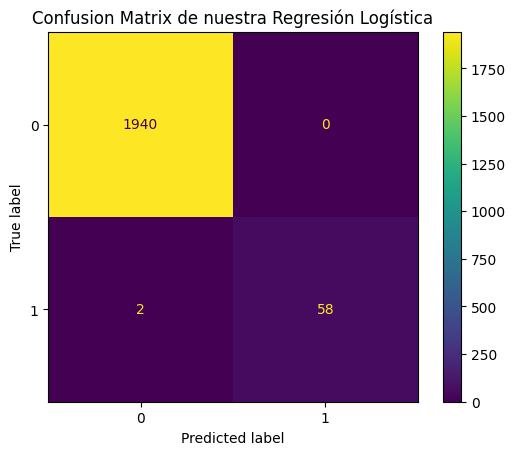

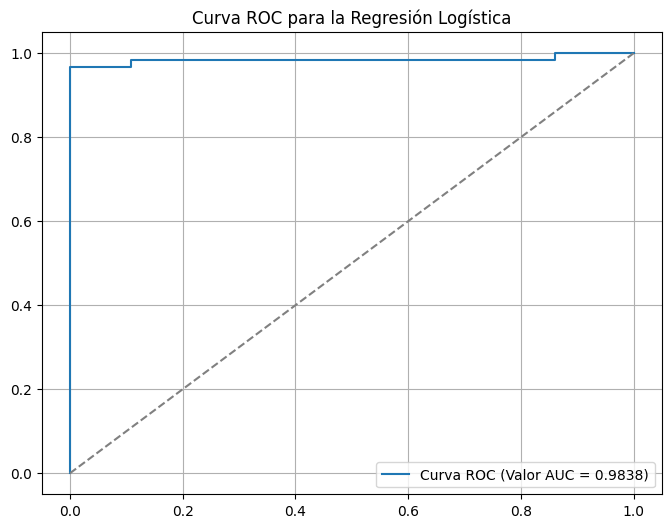

/home/unai-olaizola-osa/miniconda3/envs/ADDPLD/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/tmp/ipykernel_8295/3309797085.py:77: BentoMLDeprecationWarning: `bentoml.picklable_model` is deprecated since v1.4 and will be removed in a future version.
  bentoml.picklable_model.save_model(


Modelo de Regresión Logística guardado en la BentoML store como: Model(tag="ai4i2020_logistic_regression:s6iamdwxscbqypcv")
Scaler de Regresión Logística guardado en la BentoML store como: ai4i2020_scaler_logistic_regression


In [5]:
logistic_regression()

## 2. Algoritmos de Clasificación
Este segundo tipo de algoritmo de aprendizaje supervisado nos permitirá clasificar los diferentes tipos de fallos existentes. Como se ha explicado anteriormente, en caso de que se produzca un fallo en la máquina, este se indica mediante el valor 1 en la variable `Machine Failure` variable que hemos intentado predecir previamente mediante el uso de una regresión logística.

No obstante, el dataset ofrece información más detallada que la simple ocurrencia de un fallo, ya que incluye columnas adicionales que identifican cada tipo de error que puede producirse. Los distintos tipos de fallos están categorizados en las siguientes variables: *TWF* (fallo por desgaste de herramienta), *HDF* (fallo por una mala disipación de calor), *PWF* (fallo por una potencia fuera de rango), *OSF* (fallo por un sobreesfuerzo mecánico) y *RNF* (fallo aleatorio).

De este modo, mediante nuestros modelos de clasificación, seremos capaces de predecir el tipo de error ocurrido en aquellos casos en los que se haya producido un fallo.


### 2.1 Random Forest
Como hemos explicado anteriormente, intentaremos clasificar el tipo de error ocurrido dentro de las distintas categorías de fallos que ofrece nuestro conjunto de datos. Para ello, seguiremos un procedimiento similar al del modelo anterior, convirtiendo las columnas categóricas en variables *dummies* y separando nuevamente los datos en conjuntos de entrenamiento y test.

No obstante, al tratarse de un problema de clasificación multiclase (en nuestro caso, cinco clases, correspondientes a los cinco tipos de errores distintos), será necesario adaptar ciertas métricas de evaluación. Este es el caso de la *Precision*, el *Recall* y el *F1-Score*, para las cuales hemos optado por la variante *weighted*, que calcula el promedio de los resultados teniendo en cuenta el peso de cada clase según su número de instancias.

Utilizaremos el mismo formato de metadatos para almacenar el modelo en la *store*. Este algoritmo generará un conjunto de árboles clasificadores que intentarán identificar qué variables son las más relevantes para clasificar las instancias y, mediante un sistema de votación conjunta, devolverán el resultado final más adecuado.

Mediante el random forest intentaremos clasificar los errores de los procesos sintéticos en los 5 tipos de errores que existen y enlista nuestro dataset:
- `TWF`: Fallo por desgaste de herramienta.
- `HDF`: Fallo por una mala disipación de calor.
- `PWF`: Falla por potencia fuera de rango.
- `OSF`: Fallo por un sobreesfuerzo mecánico.
- `RNF`: Un fallo aleatorio.

In [6]:
def random_forest():
    dataset = pd.read_csv("../../data/ai4i2020_cleaned.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure", "TWF", "HDF", "PWF", "RNF", "OSF", "Product ID"]), dataset[["TWF", "HDF", "PWF", "RNF", "OSF"]]

    # Pasamos a númericas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    print(X.info())

    # Dividimos el dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # Inicializamos el modelo de regresión logística
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)

    # Realizamos las predicciones
    preds = rf.predict(X_test)

    # Por ahora solo tendremos como métrica de evaluación la accuracy
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds, average='weighted')
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds, average='weighted')
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds, average='weighted')
    print(f"F1: {f1:.4f}")

    # A partir de ahora, configuraremos el modelo para que sea compatible con BentoML
    bento_rf = bentoml.sklearn.save_model(
        "ai4i2020_random_forest",
        rf,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "clasificación con random forest",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        },
    )
    bentoml.picklable_model.save_model(
    "ai4i2020_scaler_random_forest",
    scaler
    )
    print(f"Modelo de Clasificación con Random Forest guardado en la BentoML store como: {bento_rf}")
    print(f"Scaler de Clasificación con Random Forest guardado en la BentoML store como: ai4i2020_scaler_random_forest")

Para ejecutar el Random Forest:

In [7]:
random_forest()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      9998 non-null   float64
 1   Process temperature [K]  9998 non-null   float64
 2   Rotational speed [rpm]   9998 non-null   int64  
 3   Torque [Nm]              9998 non-null   float64
 4   Tool wear [min]          9998 non-null   int64  
 5   Type_L                   9998 non-null   bool   
 6   Type_M                   9998 non-null   bool   
dtypes: bool(2), float64(3), int64(2)
memory usage: 410.2 KB
None
Accuracy obtenida: 0.9820
Precisión obtenida: 0.7683
Recall: 0.4638
F1: 0.5742


/home/unai-olaizola-osa/miniconda3/envs/ADDPLD/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Modelo de Clasificación con Random Forest guardado en la BentoML store como: Model(tag="ai4i2020_random_forest:tcp7iugxscbqypcv")
Scaler de Clasificación con Random Forest guardado en la BentoML store como: ai4i2020_scaler_random_forest


### 2.2 Suppor Vector Machines (SVMs)
Mediante este clasificador buscaremos separar, en un espacio matemático, todas aquellas instancias que difieren en el valor de la variable `Machine Failure`. Es decir, se distinguirán las instancias en las que se ha producido un fallo de aquellas en las que no, separándolas mediante vectores que nos permitirán clasificarlas y agruparlas de la forma más adecuada posible.

De este modo, volvemos a un problema de clasificación binaria, por lo que no será necesario modificar los parámetros de algunas métricas de evaluación. Como en los casos anteriores, utilizaremos el mismo procedimiento general de preparación de los datos; sin embargo, este algoritmo se caracteriza por ser más costoso computacionalmente y por requerir un mayor tiempo de entrenamiento.

Cabe destacar que, en las primeras rondas de entrenamiento, se obtuvieron métricas y visualizaciones poco representativas, debido a que el dataset se encuentra seriamente desbalanceado. Esta situación provocó que la *Accuracy* presentara valores muy elevados, mientras que otras métricas mostraban resultados muy deficientes. Por este motivo, fue necesario aplicar técnicas de equilibrado del conjunto de datos para obtener una evaluación más realista del rendimiento del modelo.


In [ ]:
def support_vector_machines():
    dataset = pd.read_csv("../../data/ai4i2020_cleaned.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure", "Product ID"]), dataset["Machine failure"]

    # Pasamos a numéricas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    print(X.info())

    # Distribución train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    # SVM mejorado
    model_svm = svm.SVC(
        kernel="rbf",
        class_weight="balanced",
        probability=True
    )
    model_svm.fit(X_train, y_train)

    # Predicciones
    preds = model_svm.predict(X_test)

    # Métricas
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds)
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds)
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds)
    print(f"F1: {f1:.4f}")
    
    # Matriz de confusión
    confusion_mat = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_mat)
    disp.plot()
    plt.title("Confusion Matrix de nuestra Clasificación con SVMs")
    plt.show()

    # Plot de los SVMs
    pca = PCA(n_components=2)
    X_test_pca = pca.fit_transform(X_test)

    # Reentrenamos el modelo usando los componentes PCA
    svm_pca = svm.SVC(kernel='rbf', probability=True)
    svm_pca.fit(pca.transform(X_train), y_train)

    # Crear una malla para dibujar la frontera de decisión
    x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
    y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    
    # Plot final (lo que queráis, puede ser opcional por mi parte)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)
    plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="coolwarm", s=20, edgecolor="k")
    plt.title("Plot de las SVMs en un espacio bidimensional (con PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    

    # A partir de ahora, configuraremos el modelo para BentoML
    bento_svm = bentoml.sklearn.save_model(
        "ai4i2020_support_vector_machine",
        model_svm,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "clasificación con svms",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": confusion_mat.tolist()
        },
    )
    bentoml.picklable_model.save_model(
    "ai4i2020_scaler_svm",
    scaler
    )
    print(f"Modelo de SVM guardado como: {bento_svm}")
    print(f"Scaler guardado en la BentoML store como: ai4i2020_scaler_svm")

Ejecutémoslo:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      9998 non-null   float64
 1   Process temperature [K]  9998 non-null   float64
 2   Rotational speed [rpm]   9998 non-null   int64  
 3   Torque [Nm]              9998 non-null   float64
 4   Tool wear [min]          9998 non-null   int64  
 5   TWF                      9998 non-null   int64  
 6   HDF                      9998 non-null   int64  
 7   PWF                      9998 non-null   int64  
 8   OSF                      9998 non-null   int64  
 9   RNF                      9998 non-null   int64  
 10  Type_L                   9998 non-null   bool   
 11  Type_M                   9998 non-null   bool   
dtypes: bool(2), float64(3), int64(7)
memory usage: 800.8 KB
None
Accuracy obtenida: 0.9990
Precisión obtenida: 1.0000
Recall: 0.9667
F1:

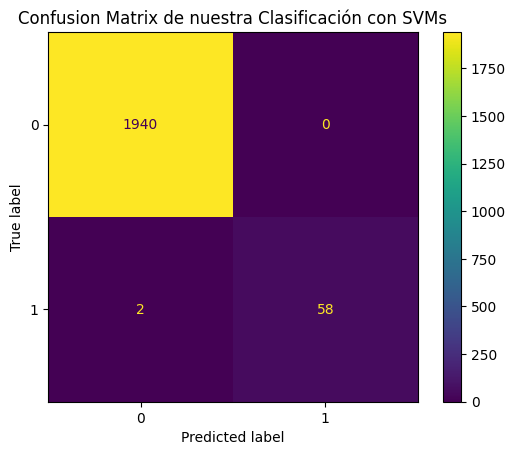

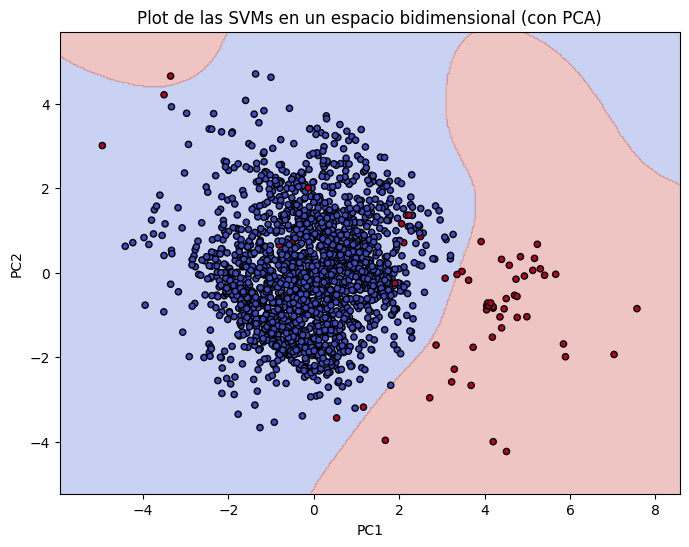

Modelo de SVM guardado como: Model(tag="ai4i2020_support_vector_machine:wiiojagxscbqypcv")
Scaler guardado en la BentoML store como: ai4i2020_scaler_svm


In [16]:
support_vector_machines()

### 2.3 XGBoost (XGBClassifier)
Este algoritmo, especializado en el *gradient boosting*, combina diferentes árboles de decisión de forma similar a *Random Forest*; sin embargo, en este caso, cada árbol intenta corregir los fallos o errores cometidos por los árboles de la capa anterior. De este modo, el modelo va mejorando progresivamente su capacidad predictiva a través de sus distintas iteraciones.

Aunque seguimos empleando los mismos pasos generales de preparación y entrenamiento, este algoritmo es sensible a ciertos caracteres que pueden provocar errores o un funcionamiento incorrecto. Por esta razón, realizaremos una limpieza previa de los datos, eliminando o sustituyendo dichos caracteres mediante funciones de reemplazo (como la función *replace*).


In [10]:
def xgb_classifier():
    dataset = pd.read_csv("../../data/ai4i2020_cleaned.csv")

    # Como X cogemos todas las columnas menos la variable que usaremos como 'y' y la variable de identificador
    X, y = dataset.drop(columns=["UDI", "Machine failure", "Product ID"]), dataset["Machine failure"] 

    # Pasamos a númericas las variables categóricas
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)

    # Eliminamos los caracteres conflictivos para que nuestro clasificador funcione correctamente
    X.columns = (X.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.replace('<', '', regex=False))

    print(X.info())

    # Dividimos el dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test  = scaler.transform(X_test)

    xgbc = XGBClassifier(eval_metric="logloss")
    xgbc.fit(X_train, y_train)

    # Realizamos las predicciones
    preds = xgbc.predict(X_test)

    # Por ahora solo tendremos como métrica de evaluación la accuracy
    accuracy = accuracy_score(y_test, preds)
    print(f"Accuracy obtenida: {accuracy:.4f}")

    precision = precision_score(y_test, preds)
    print(f"Precisión obtenida: {precision:.4f}")

    recall = recall_score(y_test, preds)
    print(f"Recall: {recall:.4f}")

    f1 = f1_score(y_test, preds)
    print(f"F1: {f1:.4f}")

    confusion_mat = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_mat)
    disp.plot()
    plt.title("Confusion Matrix de nuestra Clasificación con XGBoostClassifier")
    plt.show()

    # Plot de Curva ROC
    y_prob = xgbc.predict_proba(X_test)[:, 1]  
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"Curva ROC (Valor AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="grey")  
    plt.title("Curva ROC para la Regresión Logística")
    plt.legend()
    plt.grid(True)
    plt.show()

    # A partir de ahora, configuraremos el modelo para que sea compatible con BentoML
    bento_xgbc = bentoml.sklearn.save_model(
        "ai4i2020_xgbclassifier",
        xgbc,
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "dataset": "ai4i2020",
            "framework": "scikit-learn",
            "algoritmo": "clasificación con xgbclassifier",
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "confusion_matrix": confusion_mat.tolist()
        },
    )
    bentoml.picklable_model.save_model(
    "ai4i2020_scaler_xgbclassifier",
    scaler
    )
    print(f"Modelo de Clasificación con XGBoostClassifier guardado en la BentoML store como: {bento_xgbc}")
    print(f"Scaler guardado en la BentoML store como: ai4i2020_scaler_xgbclassifier")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9998 entries, 0 to 9997
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Air temperature K      9998 non-null   float64
 1   Process temperature K  9998 non-null   float64
 2   Rotational speed rpm   9998 non-null   int64  
 3   Torque Nm              9998 non-null   float64
 4   Tool wear min          9998 non-null   int64  
 5   TWF                    9998 non-null   int64  
 6   HDF                    9998 non-null   int64  
 7   PWF                    9998 non-null   int64  
 8   OSF                    9998 non-null   int64  
 9   RNF                    9998 non-null   int64  
 10  Type_L                 9998 non-null   bool   
 11  Type_M                 9998 non-null   bool   
dtypes: bool(2), float64(3), int64(7)
memory usage: 800.8 KB
None
Accuracy obtenida: 0.9990
Precisión obtenida: 1.0000
Recall: 0.9667
F1: 0.9831


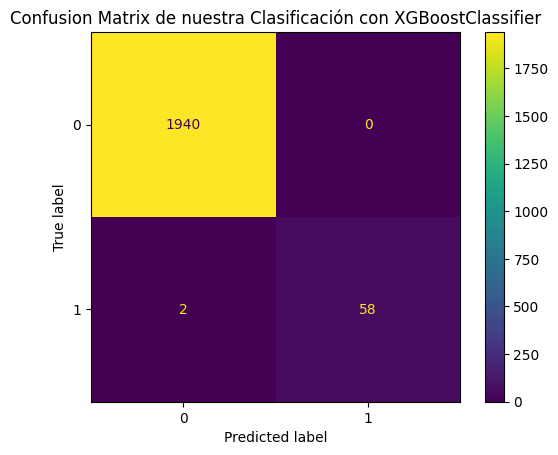

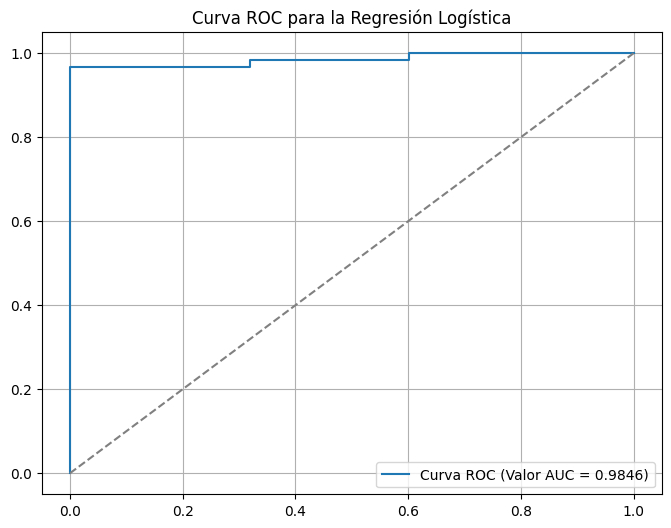

Modelo de Clasificación con XGBoostClassifier guardado en la BentoML store como: Model(tag="ai4i2020_xgbclassifier:tpd5uwgxscbqypcv")
Scaler guardado en la BentoML store como: ai4i2020_scaler_xgbclassifier


In [11]:
xgb_classifier()

# Algoritmos de Aprendizaje No Supervisado
Aunque hemos preferido centrarnos en los algoritmos de aprendizaje supervisado para predecir y clasificar
los fallos, también hemos querido experimentar con el aprendizaje no supervisado. En vez de contar con
un label indicativo por instancia e intentar predecir o clasificar un o varios posibles outcomes, mediante el
aprendizaje no supervisado intentaremos encontrar diferentes patrones para agrupar nuestras instancias
en los subgrupos m´as similares entre ellos.

## 3. Algoritmos de Agrupación (Clustering)
Los algoritmos de agrupación se encargarán en ordenar en sub-grupos, todas aquellas instancias que compartan similitudes matemáticas en un espacio ficticio. 

### 3.1 HDBSCAN
Al no contar ahora con una variable dependiente que predecir, descartaremos todas aquellas variables insignificantes o relacionadas con fallos maquinarios al seleccionar las variables que formarán *X*, quedándonos únicamente con las variables del proceso relacionadas directamente con la máquina, como la temperatura, velocidad, rotación, entre otras.

Dado que trabajamos con un algoritmo totalmente distinto a los anteriores, será necesario emplear métricas de evaluación específicas para algoritmos de aprendizaje no supervisado; en nuestro caso, utilizaremos el *Silhouette Score*, que mide la calidad de las agrupaciones o *clusters*.

En cuanto a la visualización e interpretación, hemos empleado técnicas de reducción de dimensionalidad como el *PCA* (*Principal Component Analysis*), que se explicarán con mayor detalle en el apartado siguiente. Para que las métricas, como la distancia entre *clusters*, sean fiables, será necesario escalar y normalizar los datos previamente; para ello, utilizaremos un simple *StandardScaler()*.


In [12]:
def hdbscan_clustering():
    dataset = pd.read_csv("../../data/ai4i2020_cleaned.csv")

    X = dataset.drop(columns=["UDI", "Machine failure", "TWF", "HDF", "PWF", "RNF", "OSF", "Product ID"], errors='ignore')
    columnas_categoricas = X.select_dtypes(include=["object"]).columns
    
    X = pd.get_dummies(X, columns=columnas_categoricas, drop_first=True)
    X.columns = (X.columns.str.replace("[", "", regex=False).str.replace("]", "", regex=False).str.replace("<", "", regex=False))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Creamos y ajustamos HDBSCAN
    print("Entrenando HDBSCAN...")
    hdb = HDBSCAN(min_cluster_size=3)
    labels = hdb.fit_predict(X_scaled) 

    # Métricas y Gráficas
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"Número de clusters encontrados: {n_clusters}")
    if len(set(labels)) > 1:
        silouhette = silhouette_score(X_scaled, labels)
        print(f"Silhouette Score: {silouhette:.4f}")
    else:
        silouhette = 0
        print("No se pudo calcular Silhouette (solo 1 cluster o ruido).")

    # Visualización (Opcional, igual que antes)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=15, alpha=0.8)
    plt.title("HDBSCAN clustering (Replicado)")
    plt.show()

    # Entrenamos un KNN para aprender los clusters
    # Usamos k=1 para que asigne el cluster del punto más cercano conocido
    print("Entrenando clasificador KNN para hacer el modelo 'predecible'...")
    knn_predictor = KNeighborsClassifier(n_neighbors=1)
    knn_predictor.fit(X_scaled, labels)

    bento_hdbscan = bentoml.sklearn.save_model(
        "ai4i2020_hdbscan",
        knn_predictor,  # <--- Guardamos el KNN
        metadata={
            "fecha_entrenamiento": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            "original_algorithm": "HDBSCAN (sklearn)",
            "proxy_algorithm": "KNeighborsClassifier",
            "silhouette_score": silouhette
        },
    )
    
    bentoml.picklable_model.save_model("ai4i2020_scaler_hdbscan", scaler)
    
    print(f"Modelo de Clustering con HDBSCAN guardado en la BentoML store como: {bento_hdbscan}")
    print(f"Scaler guardado en la BentoML store como: ai4i2020_scaler_hdbscan")

Entrenando HDBSCAN...


/home/unai-olaizola-osa/miniconda3/envs/ADDPLD/lib/python3.13/site-packages/sklearn/cluster/_hdbscan/hdbscan.py:722: FutureWarning: The default value of `copy` will change from False to True in 1.10. Explicitly set a value for `copy` to silence this warning.
  warn(


Número de clusters encontrados: 3
Silhouette Score: 0.2024


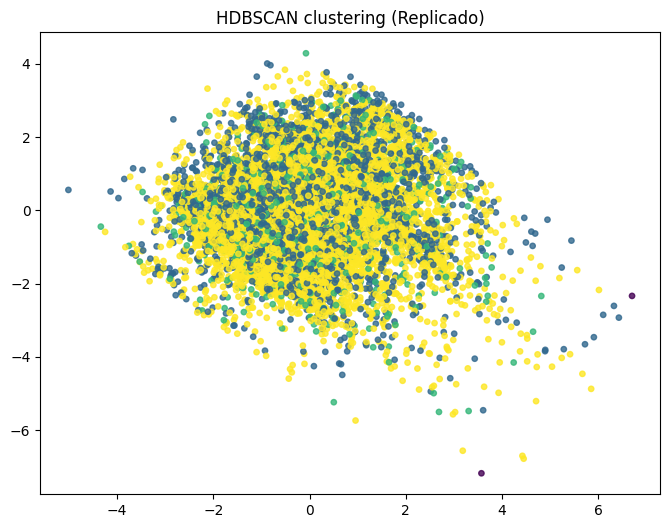

Entrenando clasificador KNN para hacer el modelo 'predecible'...
Modelo de Clustering con HDBSCAN guardado en la BentoML store como: Model(tag="ai4i2020_hdbscan:tvmco2wxscbqypcv")
Scaler guardado en la BentoML store como: ai4i2020_scaler_hdbscan


In [13]:
hdbscan_clustering()

## Para alistar los modelos creados en la BentoML Store:
Al ejecutar el siguiente comando, podremos ver datos sobre el modelo como su nombre (con su tag), el módulo usado, el tamaño final del modelo y la fecha de creación del modelo. Cada vez que ejecutemos una función que llame al entrenamiento de un algoritmo, se creará otro con un tag distinto. Pudiendo haber más de una instancia por algoritmo, el tag los diferenciará. En el caso de que queramos eliminar una instancia, tendremos que usar el siguiente comando:

```bash
bendoml models delete <nombre del modelo (con su tag)>
```
Usaré el siguiente comando para alistar todos los modelos creados y disponibles en la BentoML Store.

In [14]:
!bentoml models list

/home/unai-olaizola-osa/miniconda3/envs/ADDPLD/lib/python3.13/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
 Tag                    Module                  Size        Creation Time       
 ai4i2020_scaler_hdbs…  bentoml.picklable_mod…  1.17 KiB    2025-12-12 20:27:36 
 ai4i2020_hdbscan:tvm…  bentoml.sklearn         1.29 MiB    2025-12-12 20:27:36 
 ai4i2020_scaler_xgbc…  bentoml.picklable_mod…  1.32 KiB    2025-12-12 20:27:34 
 ai4i2020_xgbclassifi…  bentoml.sklearn         120.54 KiB  2025-12-12 20:27:33 
 ai4i2020_scaler_svm:…  bentoml.picklable_mod…  1.32 KiB    2025-12-12 20:27:32 
 ai4i2020_support_vec…  bentoml.sklearn         41.24 KiB   2025-12-12 20:27:31 
 ai4i2020_scaler_rand… 